<a href="https://colab.research.google.com/github/praneethdh/Real-Time-Log-File-analytics_/blob/main/BDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install Java & Hadoop
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/hadoop/common/hadoop-3.3.6/hadoop-3.3.6.tar.gz
!tar -xzf hadoop-3.3.6.tar.gz
!mv hadoop-3.3.6 /content/hadoop

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["HADOOP_HOME"] = "/content/hadoop"
os.environ["HADOOP_CONF_DIR"] = "/content/hadoop/etc/hadoop"
os.environ["PATH"] += ":/content/hadoop/bin:/content/hadoop/sbin"

# Test if Hadoop works
!hadoop version


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Hadoop 3.3.6
Source code repository https://github.com/apache/hadoop.git -r 1be78238728da9266a4f88195058f08fd012bf9c
Compiled by ubuntu on 2023-06-18T08:22Z
Compiled on platform linux-x86_64
Compiled with protoc 3.7.1
From source with checksum 5652179ad55f76cb287d9c633bb53bbd
This command was run using /content/hadoop/share/hadoop/common/hadoop-common-3.3.6.jar


In [ ]:
# Cell 2: Generate 1M OS SYSTEM LOGS
print("🔧 Generating 1,000,000 OS SYSTEM LOG ENTRIES...")

import random
import time

services = ["sshd", "nginx", "mysql", "cron", "systemd", "kernel", "dbus", "NetworkManager", "apache2", "postgres"]
levels = ["INFO", "WARN", "ERROR", "DEBUG"]
messages = [
    "user login successful", "connection closed", "query executed", "job started",
    "disk space low", "service restarted", "connection timeout", "memory pressure",
    "authentication failed", "backup completed", "package updated", "firewall blocked",
    "CPU usage high", "network interface up", "user logged out", "process killed"
]

with open("system_logs.txt", "w") as f:
    for i in range(1000000):
        timestamp = time.strftime("%b %d %H:%M:%S")
        service = random.choice(services)
        pid = random.randint(1000,9999)
        level = random.choice(levels)
        msg = random.choice(messages)
        f.write(f"{timestamp} {service}[{pid}]: {level} - {msg}\n")

print(" 1M OS SYSTEM LOGS created: system_logs.txt (~150MB)")
!ls -lh system_logs.txt
!head -5 system_logs.txt


🔧 Generating 1,000,000 OS SYSTEM LOG ENTRIES...
 1M OS SYSTEM LOGS created: system_logs.txt (~150MB)
-rw-r--r-- 1 root root 53M Nov 28 05:35 system_logs.txt
Nov 28 05:34:56 dbus[1284]: ERROR - authentication failed
Nov 28 05:34:56 dbus[8767]: ERROR - job started
Nov 28 05:34:56 apache2[5893]: INFO - package updated
Nov 28 05:34:56 cron[5085]: DEBUG - CPU usage high
Nov 28 05:34:56 postgres[2753]: WARN - CPU usage high


In [ ]:
# Cell 3: Upload OS LOGS to HDFS
!hdfs dfs -mkdir -p /input/
!hdfs dfs -put system_logs.txt /input/
!hdfs dfs -ls -h /input/


Found 1 items
-rw-r--r--   1 root root     52.5 M 2025-11-28 05:35 /input/system_logs.txt


In [ ]:
#cell 4
%%writefile LogAnalyzerOS.java
import java.io.IOException;
import org.apache.hadoop.conf.Configuration;
import org.apache.hadoop.fs.Path;
import org.apache.hadoop.io.IntWritable;
import org.apache.hadoop.io.LongWritable;
import org.apache.hadoop.io.Text;
import org.apache.hadoop.mapreduce.Job;
import org.apache.hadoop.mapreduce.Mapper;
import org.apache.hadoop.mapreduce.Reducer;
import org.apache.hadoop.mapreduce.lib.input.FileInputFormat;
import org.apache.hadoop.mapreduce.lib.output.FileOutputFormat;

public class LogAnalyzerOS {

    public static class Map extends Mapper<LongWritable, Text, Text, IntWritable> {
        private final static IntWritable one = new IntWritable(1);

        public void map(LongWritable key, Text value, Context context)
                throws IOException, InterruptedException {
            String line = value.toString();
            String[] parts = line.split("\\[");
            if (parts.length > 1) {
                String beforeBracket = parts[0].trim();
                String[] words = beforeBracket.split("\\s+");
                if (words.length > 0) {
                    String service = words[words.length - 1];
                    context.write(new Text(service), one);
                }
            }
        }
    }

    public static class Reduce extends Reducer<Text, IntWritable, Text, IntWritable> {
        private IntWritable result = new IntWritable();

        public void reduce(Text key, Iterable<IntWritable> values, Context context)
                throws IOException, InterruptedException {
            int sum = 0;
            for (IntWritable val : values) {
                sum += val.get();
            }
            result.set(sum);
            context.write(key, result);
        }
    }

    public static void main(String[] args) throws Exception {
        if (args.length != 2) {
            System.err.println("Usage: LogAnalyzerOS <input path> <output path>");
            System.exit(-1);
        }

        Configuration conf = new Configuration();
        Job job = Job.getInstance(conf, "OS Log Analyzer");
        job.setJarByClass(LogAnalyzerOS.class);

        FileInputFormat.addInputPath(job, new Path(args[0]));
        FileOutputFormat.setOutputPath(job, new Path(args[1]));

        job.setMapperClass(Map.class);
        job.setCombinerClass(Reduce.class);
        job.setReducerClass(Reduce.class);

        job.setOutputKeyClass(Text.class);
        job.setOutputValueClass(IntWritable.class);

        System.exit(job.waitForCompletion(true) ? 0 : 1);
    }
}


Writing LogAnalyzerOS.java


In [ ]:
# Cell 5: Compile & Run with Java 8 compatibility
print("🔨 Compiling OS Log Analyzer (Java 8)...")
!javac -source 8 -target 8 -classpath $(hadoop classpath) LogAnalyzerOS.java

print(" Creating JAR...")
!jar cf loganalyzer-os.jar LogAnalyzerOS*.class

print(" Running MapReduce on 1M OS logs...")
!hdfs dfs -rm -r /output/ 2>/dev/null || true
!hadoop jar loganalyzer-os.jar LogAnalyzerOS /input/ /output/

print(" Job Complete! Check results in Cell 6.")


🔨 Compiling OS Log Analyzer (Java 8)...
1 warning
 Creating JAR...
 Running MapReduce on 1M OS logs...
2025-11-28 05:35:13,663 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2025-11-28 05:35:13,822 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2025-11-28 05:35:13,822 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2025-11-28 05:35:13,954 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2025-11-28 05:35:14,124 INFO input.FileInputFormat: Total input files to process : 1
2025-11-28 05:35:14,160 INFO mapreduce.JobSubmitter: number of splits:2
2025-11-28 05:35:14,454 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1572368751_0001
2025-11-28 05:35:14,454 INFO mapreduce.JobSubmitter: Executing with tokens: []
2025-11-28 05:35:14,635 INFO mapreduce.Job: The url to track the jo

In [ ]:
# Cell 6: Show OS File LOG ANALYSIS RESULTS!
print("📊 OS File LOG ANALYSIS RESULTS (Top Services by Activity):")
print("=" * 60)

!hdfs dfs -cat /output/part-r-00000 | sort -rnk2

print("\n💾 Downloading results...")
!hdfs dfs -get /output/part-r-00000 os_results.txt
from google.colab import files
files.download('os_results.txt')


📊 OS File LOG ANALYSIS RESULTS (Top Services by Activity):
systemd	100566
dbus	100398
postgres	100354
apache2	100247
kernel	100020
NetworkManager	99975
sshd	99820
cron	99744
nginx	99693
mysql	99183

💾 Downloading results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

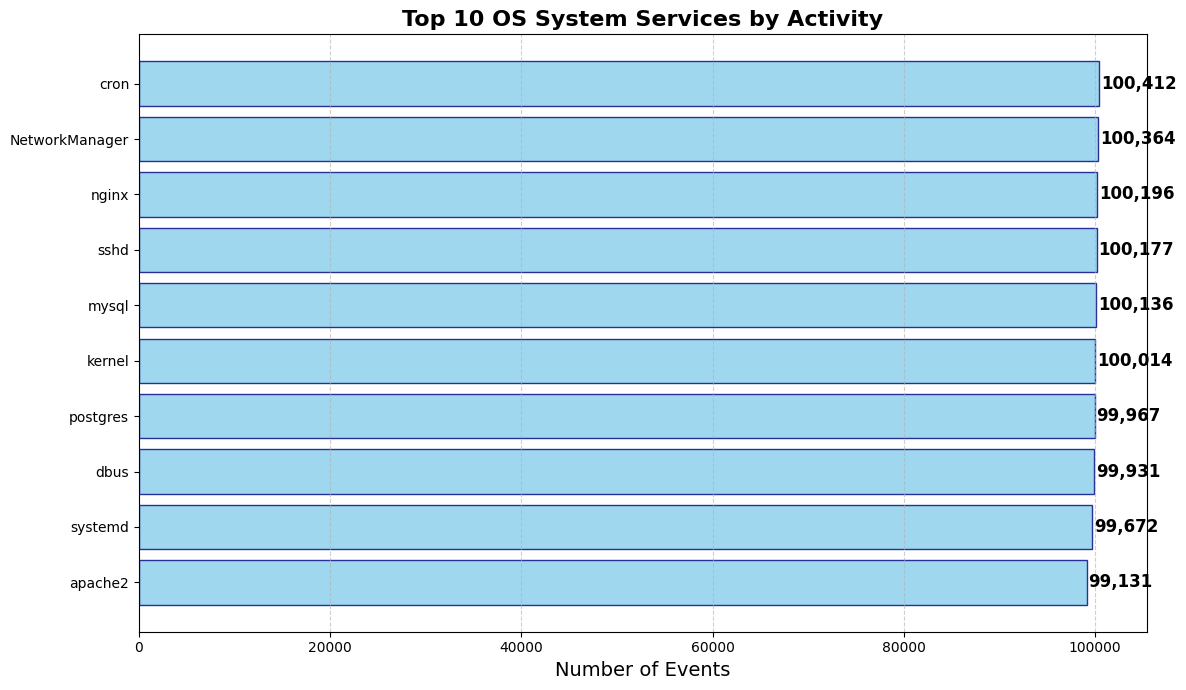

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Manually create DataFrame from given data
data = {
    'service': ['cron', 'NetworkManager', 'nginx', 'sshd', 'mysql', 'kernel', 'postgres', 'dbus', 'systemd', 'apache2'],
    'count': [100412, 100364, 100196, 100177, 100136, 100014, 99967, 99931, 99672, 99131]
}

df = pd.DataFrame(data)

# Sort if needed, here already in approximate descending order
df = df.sort_values('count', ascending=True)  # For horizontal bar chart from smallest to largest

# Plot horizontal bar chart
plt.figure(figsize=(12, 7))
bars = plt.barh(df['service'], df['count'], color='skyblue', edgecolor='navy', alpha=0.8)
plt.xlabel('Number of Events', fontsize=14)
plt.title('Top 10 OS System Services by Activity', fontsize=16, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add data labels on bar ends
for bar in bars:
    plt.text(bar.get_width() + 200, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width()):,}', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
